# Imports

In [3]:
import jieba
from jieba import posseg as pseg

import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
from math import exp
import seaborn as sns
sns.set_theme()

df = pd.read_excel("CAC.xlsx")
df_comments = df.loc[df["status"] == "doc issued after public comments"].reset_index(drop=True)


# Similarity functions

In [4]:
js = []
cs = []
ed = []

def jaccard_similarity(set1, set2):
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))
     
    return intersection / union

def get_cosine_similarity(documents):
    
    def clean_text(text):
        jieba_stop_words = ['的', '了', '和', '是', '就', '都', '而', '及', '與', 
                            '著', '或', '一個', '沒有', '我們', '你們', '妳們', 
                            '他們', '她們', '是否']
        sentence = [re.sub ("\/", "_", str (item)) for item in pseg.cut(text)] 
        sentence = [word for word in sentence if not re.search ("_ns|_x|_m", word)] #exclude place names, non-morphemes, measures 
        sentence = [word for word in sentence if not word in jieba_stop_words]
        #sentence = [word for word in sentence if len (re.sub ("_.*", "", word))>1] #restrict to two-character words
        #sentence = [word for word in sentence if re.search ("_n|_v|_j", word)] #restrict to nouns, verbs, adjectives,  
        return ' '.join(list(re.sub ("_.*", "", word) for word in sentence))
    new_docs = []
    
    for doc in documents:
        new_docs.append(clean_text(doc))
        
    count_vectorizer = CountVectorizer()
    sparse_matrix = count_vectorizer.fit_transform(new_docs)
    doc_term_matrix = sparse_matrix.todense()
    df = pd.DataFrame(
       doc_term_matrix,
       columns=count_vectorizer.get_feature_names_out(),
       index=["full", "draft"],
    )
    #print(df)
    cs = cosine_similarity(df, df)[0][1]
    
    
    #cs = cs[0].astype(int)
    return cs

# Execute functions

In [5]:
for i in range(len(df_comments)):
    t = str(df_comments["text_final"][i])
    t = re.sub("[^\u4e00-\u9FFF\d]", "", t)
    fulltext_split = " ".join(jieba.cut(t, use_paddle=True))
    f_s = set(fulltext_split.split(" "))
    #print(fulltext_split)
    
    d = str(df_comments["text_draft"][i])
    d = re.sub("[^\u4e00-\u9FFF\d]", "", d)
    draft_split = " ".join(jieba.cut(d, use_paddle=True))
    d_s = set(draft_split.split(" "))
    
    
    s = jaccard_similarity(f_s, d_s)
    documents = [fulltext_split, draft_split]
    c = get_cosine_similarity(documents)
    
    js.append(s)
    cs.append(c)
    
    
df_comments["jaccard_similarity"] = js
df_comments["cosine_similarity"] = cs

df_comments = df_comments.loc[df_comments["cosine_similarity"] > 0].reset_index(drop=True)
df_comments.to_excel("CAC_Analysis.xlsx")


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\vbrus\AppData\Local\Temp\jieba.cache
Loading model cost 0.614 seconds.
Prefix dict has been built successfully.


# Analysis

-0.24848867584001955
-0.3808707744757957
-0.6607413057580653
-0.6678770291138744
-0.4399251981948196
0.009550817360345997


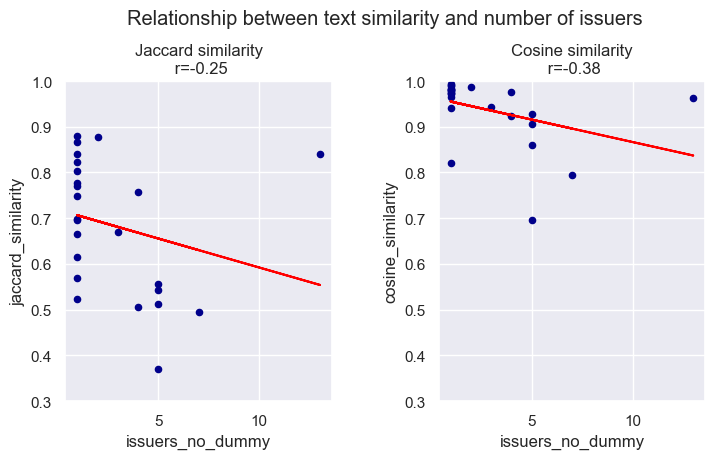

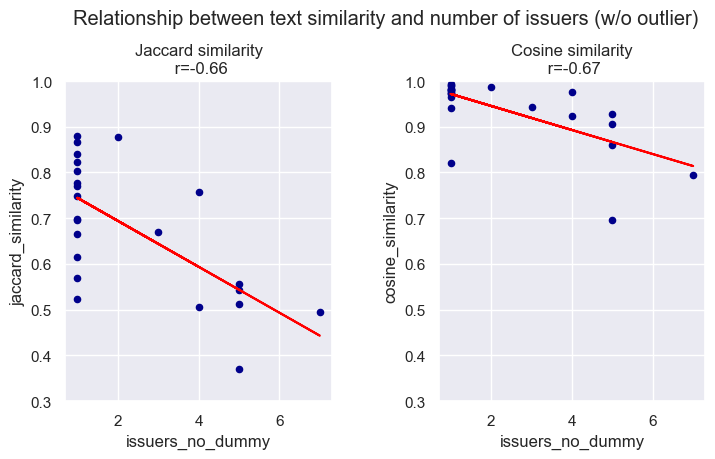

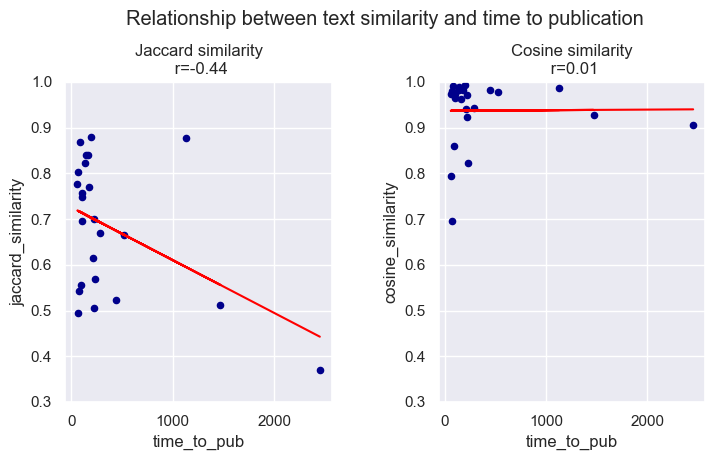

In [6]:
import matplotlib
import math
from sklearn.linear_model import LinearRegression

matplotlib.rcParams['figure.figsize'] = [8, 4]

def similarity_scatterplots(df, x, title, remove_outlier=False):
    sim_types = ["jaccard_similarity", "cosine_similarity"]
    sim_labels = ["Jaccard similarity", "Cosine similarity"]
    
    if remove_outlier:
        df = df[df["title"].str.contains("网络安全审查办法")==False].reset_index(drop=True)
    
    def round_half_up(n, decimals=0):
        multiplier = 10**decimals
        return math.floor(n * multiplier + 0.5) / multiplier
    
    fig, axes = plt.subplots(1, len(sim_types))
    fig.suptitle(title)
    plt.subplots_adjust(left=0.1,
                    bottom=0, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.4, 
                    hspace=0.4)
    count = 0
    for r in range(len(sim_types)):
        
        
        r = np.corrcoef(df[x], df[sim_types[count]])[0,1]
        print(r)
        r = round_half_up(r, 2)
        
        ax = df.plot.scatter(x=x,
                          y=sim_types[count],
                          c='DarkBlue',
                          ax=axes[count])
        
        
        X = df[x].values.reshape(-1, 1)
        Y = df[sim_types[count]].values.reshape(-1, 1)
        
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        Y_pred = linear_regressor.predict(X)
        
        ax.plot(df[x], Y_pred, color='red')
                
        
        ax.set_ylim([0.3, 1])
        ax.set_title(sim_labels[count] + f"\n r={str(r)}")
        count += 1
    
similarity_scatterplots(df_comments, "issuers_no_dummy", "Relationship between text similarity and number of issuers")
similarity_scatterplots(df_comments, "issuers_no_dummy", "Relationship between text similarity and number of issuers (w/o outlier)", remove_outlier=True)
similarity_scatterplots(df_comments, "time_to_pub", "Relationship between text similarity and time to publication")


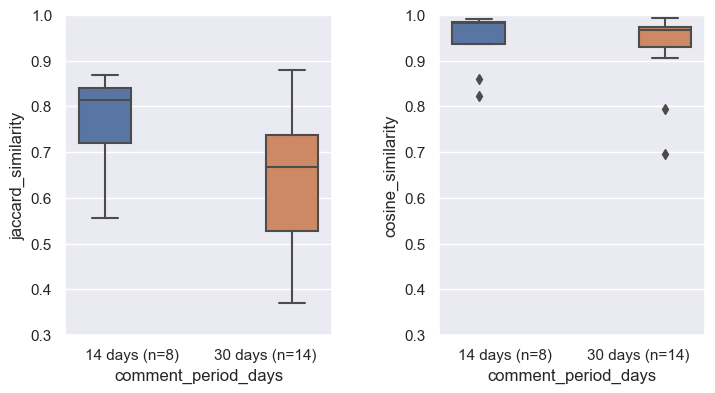

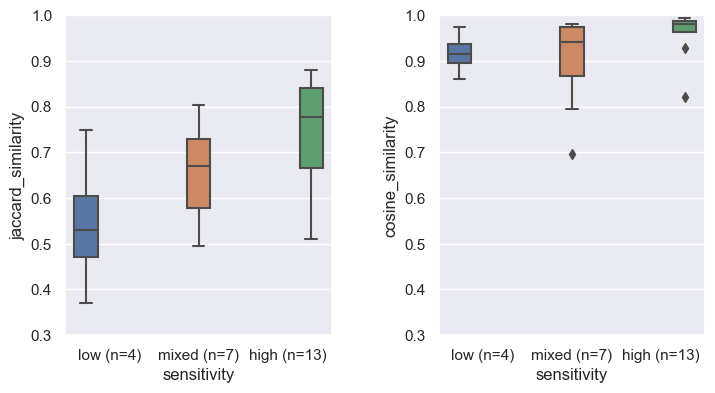

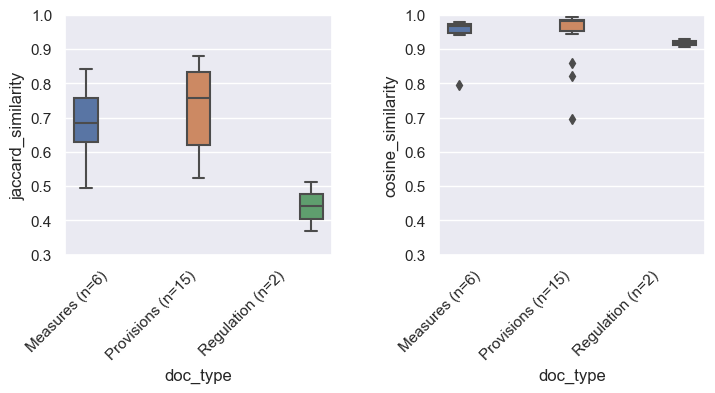

In [8]:
def sim_boxplot(x, df_comments, varss, labels):
    
    sim_types = ["jaccard_similarity", "cosine_similarity"]
    fig, axes = plt.subplots(1, len(sim_types))
    
    plt.subplots_adjust(left=0.1,
                bottom=0, 
                right=0.9, 
                top=0.8, 
                wspace=0.4, 
                hspace=0.4)

    count = 0
    for sim in sim_types:
        df = df_comments[[x, sim]]
        
        # maintain only the categories supplied manually in func arguments
        df = df[df[x].isin(varss)].reset_index(drop=True)
        
        df[x] = df[x].astype('category')
        df[x] = df[x].cat.set_categories(varss)
        df = df.sort_values(x)
        
        def replace_labels(df, varrs, labels):
            for i in range(len(varrs)):
                var = varrs[i]
                label = labels[i]
                ln = int(len(df.loc[df[x] == var]))
                
                df[x] = [f"{label} (n={str(ln)})" if x == var else x for x in df[x]]
            return df
        
        df = replace_labels(df, varss, labels)
        
        a = sns.boxplot(x=df[x], y=df[sim], hue=df[x], ax=axes[count])
        axes[count].set_ylim([0.3, 1])
        if len(labels[0]) >= 8:
            fig.autofmt_xdate(rotation=45)
        axes[count].legend([],[], frameon=False)
        count += 1
        

sim_boxplot('comment_period_days', df_comments, varss=[14.0, 30.0], labels=["14 days", "30 days"])
sim_boxplot('sensitivity', df_comments, varss=['low', 'mixed', 'high'], labels=['low', 'mixed', 'high'])
sim_boxplot('doc_type', df_comments, varss=['办法', '规定', '条例'], labels=['Measures', 'Provisions', 'Regulation'])



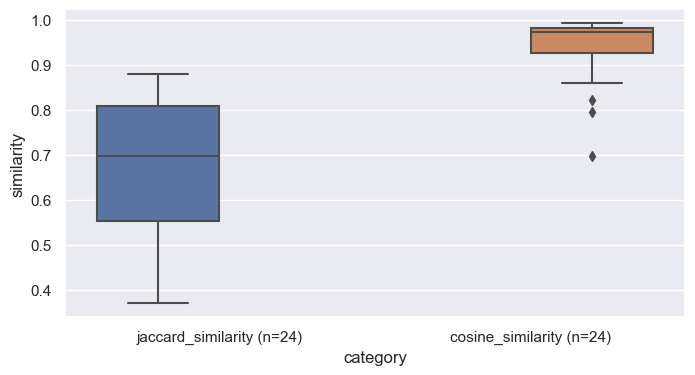

In [20]:
def boxplot(x, y, df_comments, varss, labels):
    df = df_comments[[x, y]]
        
    if x == "comment_period_days":
        """
        NOTE: variables with notice period of 21 days are removed here due to low n=2
        """
        df = df[df["comment_period_days"] != 21.0].reset_index(drop=True)

    df[x] = df[x].astype('category')
    df[x] = df[x].cat.set_categories(varss)
    df = df.sort_values(x)
    #print(df)
    
    fig, ax = plt.subplots()
    def replace_labels(df, varrs, labels):
        for i in range(len(varrs)):
            var = varrs[i]
            label = labels[i]
            ln = int(len(df.loc[df[x] == var]))

            df[x] = [f"{label} (n={str(ln)})" if x == var else x for x in df[x]]
        return df

    df = replace_labels(df, varss, labels)
    
    
    sns.boxplot(x=df[x], y=df[y], hue=df[x], ax=ax)
    plt.legend([],[], frameon=False)
#boxplot('sensitivity', "time_to_pub", df_comments, varss=['low', 'mixed', 'high'], labels=['low', 'mixed', 'high'])



sim = []
cat = []
for i in range(len(df_comments)):
    sim.append(df_comments["jaccard_similarity"][i])
    cat.append("jaccard_similarity")
    sim.append(df_comments["cosine_similarity"][i])
    cat.append("cosine_similarity")

sim_df = pd.DataFrame({"category": cat, "similarity": sim})
#print(sim_df)
boxplot("category", "similarity", sim_df, varss=['jaccard_similarity', 'cosine_similarity'], labels=['jaccard_similarity', 'cosine_similarity'])

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


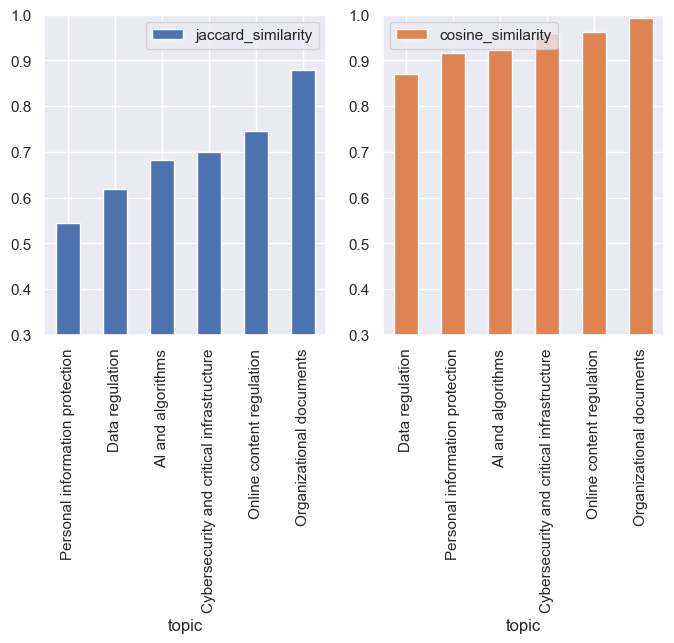

In [109]:
def sim_bar_graph(x):
    
    sim_types = ["jaccard_similarity", "cosine_similarity"]
    fig, axes = plt.subplots(1, len(sim_types))
    
    plt.subplots_adjust(
                bottom=0, 
                top=0.8, 
                wspace=0.2, 
                hspace=0.2)

    count = 0
    for sim in sim_types:
        df = df_comments[[x, sim]].groupby([x]).mean()
        
        cols = sns.color_palette().as_hex()
        df["colors"]  = cols[0:len(df)]
        
        cmap_dict = pd.Series(df.colors.values, index=df.index).to_dict()
        
        
        df = df.sort_values(by=sim)
        
        plot = df.plot.bar(ax=axes[count], color=cols[count])
        
        axes[count].set_ylim([0.3, 1])
        count += 1
        
    
sim_bar_graph("topic")
print(sns.color_palette().as_hex())


status  doc issued after public comments  no public comments
year                                                        
2014                                 NaN                 2.0
2015                                 NaN                 3.0
2016                                 1.0                 3.0
2017                                 4.0                 5.0
2018                                 NaN                 1.0
2019                                 4.0                 2.0
2021                                 4.0                 NaN
2022                                 8.0                 NaN
2023                                 4.0                 NaN


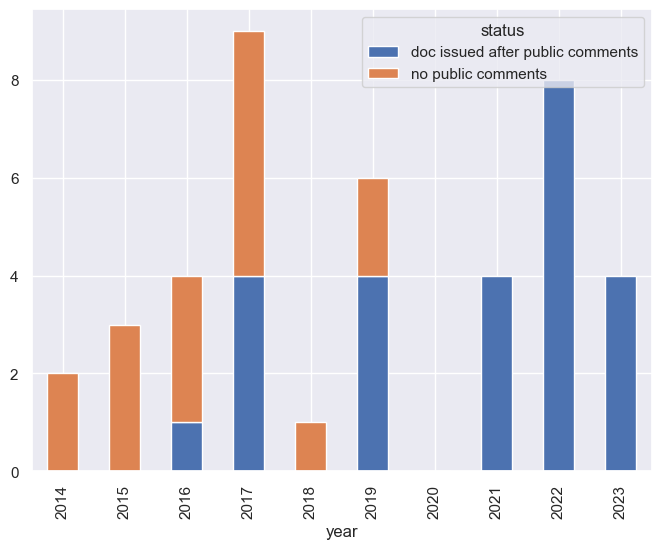

In [117]:
def calculate_percentage_public_year(df):
    df = df.loc[df['status'] != 'draft without final'].reset_index(drop=True)
    df = df.loc[df['data_category'] == 'reg'].reset_index(drop=True)
    df['year'] = df["pub_date"].astype(str).str[0:4]
    df = df.groupby(by='year')['status'].value_counts().unstack()
    print(df)
    #df.drop(df.tail(1).index,inplace=True)
    df.index = df.index.astype(int)

    df = df.reindex(range(2014, 2024))
    df.plot.bar(stacked=True, figsize=(8,6))
    
calculate_percentage_public_year(df)

14 days     9
21 days     2
30 days    22
dtype: int64


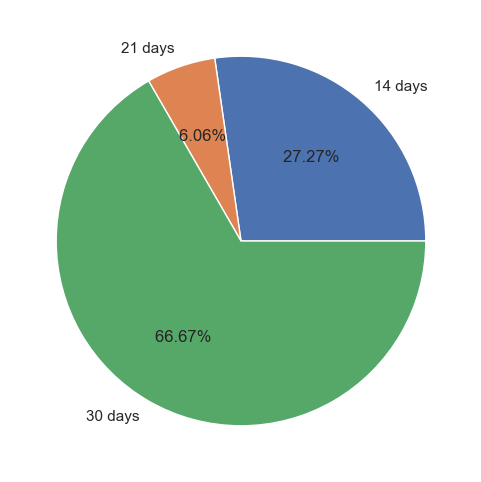

In [143]:
def get_pie_chart(df):
    df = df[['comment_period_days']].groupby('comment_period_days').value_counts()
    df.index = ['14 days', '21 days', '30 days']
    print(df)
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.2f}% '.format(p=pct,v=val)
        return my_autopct
    df.plot.pie(autopct=make_autopct(df[[0]]), figsize=(6,6))
    
get_pie_chart(df)